In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm
import time
import pickle
import sys
Tcmb=2.725
try:
    import katcali
except:
    import sys
    sys.path.insert(0, '/home/liutianyang/katcali')
    import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam_UHF as kb_u

from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
fname='1710869782'
# py_output_file='../level1/results/py_results/level1_20250306_092316/'
output_file=f'./results/py_results/cali_20250429_073640/'

In [3]:
data=kio.load_data(fname)
#print data

In [4]:
#select ant, polarization, and one channel to show data calibration
ant='m025'
pol='h'
ch_plot= 3200 #ch3608 is for 1023MHz, but Tnd and Trec models cut at 1015MHz
#UHF ch_plot: (272,2869)+(3133,3547) 

# ratio_t = 0.4
# ratio_ch = 0.5
# ratios = "{:03d}".format(int(ratio_t * 100)) + "{:03d}".format(int(ratio_ch * 100))

In [5]:
#load data, labels, and parameters
ch_ref=ch_plot
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print (corr_id,recv)

0 m025h


In [6]:
####save data####
d_r=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'/level2_data','rb'))
T_map1=d_r['T_map']
Tresi_map1=d_r['Tresi_map']
gain_map1=d_r['gain_map']

Tnd_ref_list1=d_r['Tnd_ref_list']
Tnda_list1=d_r['Tnda_list']
Tndb_list1=d_r['Tndb_list']
Tnd_diff_ratio_list1=d_r['Tnd_diff_ratio_list']
NRMSE1_list1=d_r['NRMSE1_list']
NRMSE2_list1=d_r['NRMSE2_list']

d_r2=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'/level2_Tnd_data','rb'))
Tnd_ref_list2=d_r2['Tnd_ref_list']
Tnda_list2=d_r2['Tnda_list']
Tndb_list2=d_r2['Tndb_list']



In [7]:
assert(Tnda_list1==Tnda_list2)
assert(Tndb_list1==Tndb_list2)

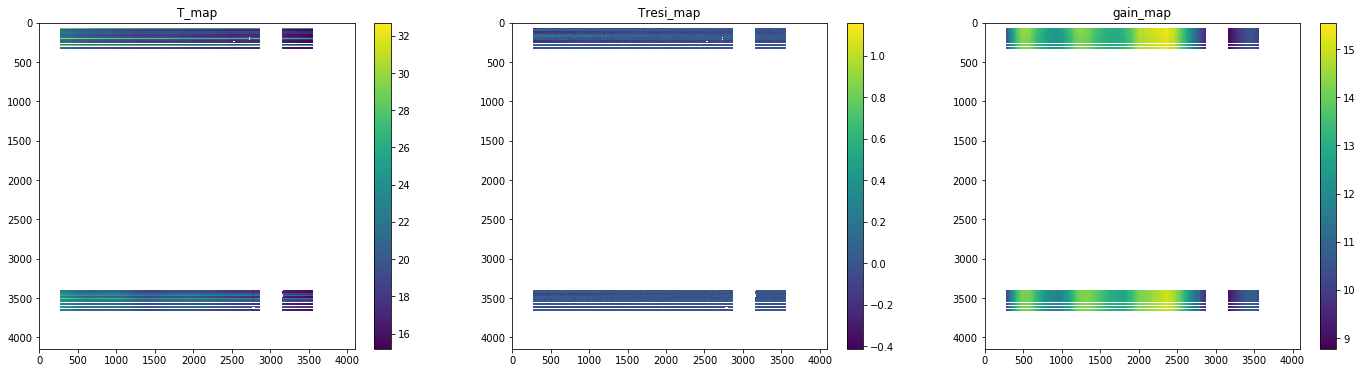

In [8]:
# T_map: raw data that are converted into temperature
# gain_map: the gain (a kind scaling factor) for comparison between raw data and model
plot_list=[T_map1,Tresi_map1,gain_map1]
plot_title=['T_map','Tresi_map','gain_map']
i=0
plt.figure(figsize=(8*len(plot_list),6))
for plot_d in plot_list:
    plt.subplot(1,len(plot_list),i+1)
    plt.imshow(plot_d,aspect='auto')
    plt.title(plot_title[i])
    plt.colorbar()
    i+=1
plt.show()

In [9]:
T_map1.shape

(4145, 4096)

In [10]:
print(np.ma.mean(T_map1[:, 3200]), np.ma.std(T_map1[:, 3200]))
print(np.ma.mean(Tresi_map1[:, 3200]), np.ma.std(Tresi_map1[:, 3200]))
print(np.ma.mean(gain_map1[:, 3170]), np.ma.std(gain_map1[:, 3170]))

18.15618389019333 2.7173590934427265
3.4959249176637875e-05 0.04971700868140661
9.114956493768545 0.14181335672210452


Text(0,0.5,'Tnd_diff_ratio')

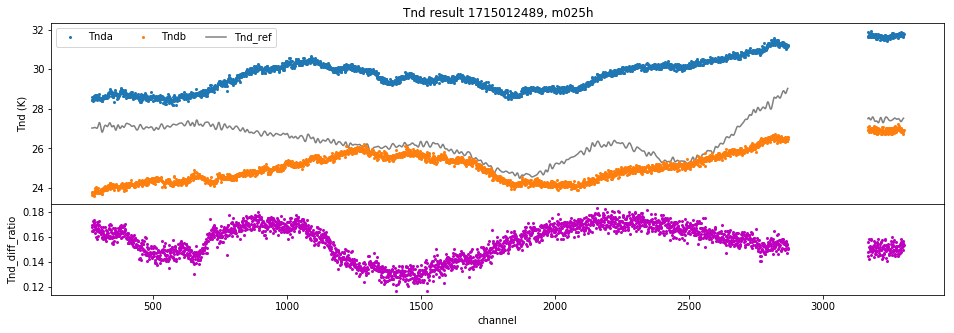

In [11]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(16,5))
plt.subplots_adjust(hspace=0)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])
plt.subplot(gs[0,0])
plt.plot(Tnda_list1,'.',ms=4)
plt.plot(Tndb_list1,'.',ms=4)
plt.plot(Tnd_ref_list1, color='grey',zorder=0)
plt.legend(['Tnda','Tndb','Tnd_ref'],ncol=3)
#plt.xlabel('channel')
plt.xticks([])
plt.ylabel('Tnd (K)')
plt.title('Tnd result '+fname+', '+recv)
plt.subplot(gs[1,0])
plt.plot(Tnd_diff_ratio_list1,'m.',ms=4)
plt.xlabel('channel')
plt.ylabel('Tnd_diff_ratio')
#plt.savefig(output_file+'Tnd_all_'+str(fname)+'_'+str(recv)+'.pdf', bbox_inches='tight')


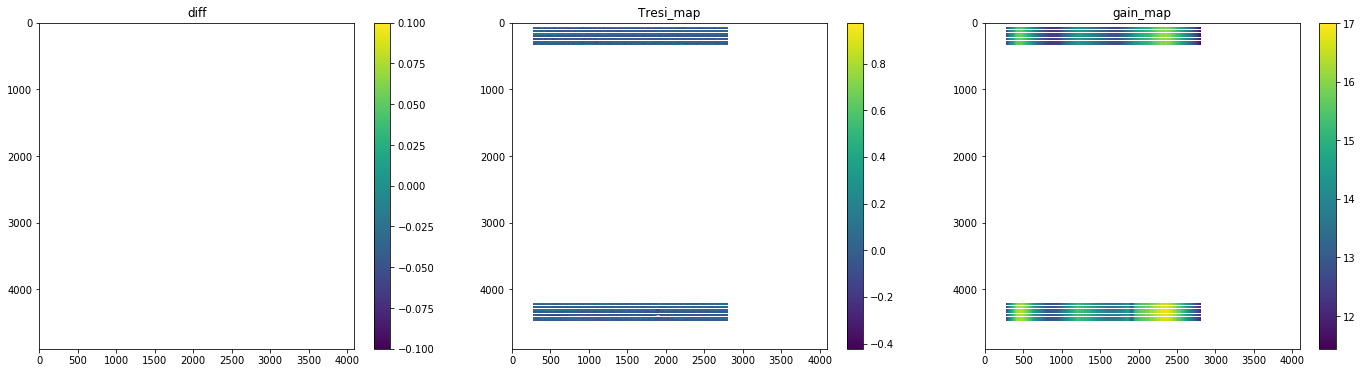

In [20]:
# T_map2 = T_map1.copy()
diff = T_map1 - T_map2
diff = np.ma.masked_where(np.abs(diff) < 1e-8, diff)

# T_map: raw data that are converted into temperature
# gain_map: the gain (a kind scaling factor) for comparison between raw data and model
plot_list=[diff,Tresi_map1,gain_map1]
plot_title=['diff','Tresi_map','gain_map']
i=0
plt.figure(figsize=(8*len(plot_list),6))
for plot_d in plot_list:
    plt.subplot(1,len(plot_list),i+1)
    plt.imshow(plot_d,aspect='auto')
    plt.title(plot_title[i])
    plt.colorbar()
    i+=1
plt.show()

In [21]:
T_map1 == T_map2

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=True)